In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.special import factorial
from pyquaternion import Quaternion

#####################################
# Cubic Bezier segment
#####################################

class CubicBezierSegment:
    def __init__(self, pnts, tangents):
        self.order = 3
        self.control_points = [np.zeros(3) for _ in range(self.order + 1)]
        self.control_points[0] = pnts[0]
        self.control_points[3] = pnts[1]
        
         # Compute alpha
        a = 16 - np.linalg.norm(tangents[0] + tangents[1])**2
        b = 12 * np.dot(self.control_points[3] - self.control_points[0], tangents[0] + tangents[1])
        c = -36 * np.linalg.norm(self.control_points[3] - self.control_points[0])**2
        alpha = np.roots([a, b, c]).max()
        
        # Compute the rest of the control points
        self.control_points[1] = self.control_points[0] + (1.0 / 3) * alpha * tangents[0]
        self.control_points[2] = self.control_points[3] - (1.0 / 3) * alpha * tangents[1]
    
    @staticmethod
    def distance(p1, p2):
        p1 = np.array(p1)
        p2 = np.array(p2)

        assert p1.size == 3 and p2.size == 3        
        return np.sqrt(np.sum((p2 - p1)**2))
        
    @staticmethod
    def generate_cubic_curve(pnts):
        assert isinstance(pnts, list), 'List of points is invalid'
        tangents = [np.zeros(3) for _ in range(len(pnts))]

        lengths = [CubicBezierSegment.distance(pnts[i + 1], pnts[i]) for i in range(len(pnts) - 1)]
        lengths = [0] + lengths
        
        # Initial vector of parametric variables for the curve
        u = [l / np.sum(lengths) for l in np.cumsum(lengths)]
        delta_u = lambda k: u[k] - u[k - 1]
        delta_q = lambda k: pnts[k] - pnts[k - 1]
        lamb_k = lambda k: delta_q(k) / delta_u(k)
        alpha_k = lambda k: delta_u(k) / (delta_u(k) + delta_u(k + 1))

        for i in range(1, len(u) - 1):            
            tangents[i] = (1 - alpha_k(i)) * lamb_k(i) + alpha_k(i) * lamb_k(i + 1)
            if i == 1:
                tangents[0] = 2 * lamb_k(i) - tangents[1]

        tangents[-1] = 2 * lamb_k(len(u) - 1) - tangents[-2]

        # Normalize tangent vectors
        for i in range(len(tangents)):
            tangents[i] = tangents[i] / np.linalg.norm(tangents[i])

        segments = list()
        # Generate the cubic Bezier curve segments
        for i in range(len(tangents) - 1):
            segments.append(CubicBezierSegment([pnts[i], pnts[i + 1]], [tangents[i], tangents[i + 1]]))

        return segments

    @staticmethod
    def _get_binomial(n, i):
        return factorial(n) / (factorial(i) * factorial(n - i))
    
    def interpolate(self, u):
        u = max(u, 0)
        u = min(u, 1)

        b = np.zeros(3)        
        for i in range(len(self.control_points)):
            b += self.compute_polynomial(self.order, i, u) * self.control_points[i]
        return b
    
    def compute_polynomial(self, n, i, u):
        return self._get_binomial(n, i) * (1 - u)**(n - i) * u**i
    
    def get_length(self):
        return self.order * np.linalg.norm(self.control_points[1] - self.control_points[0])
    
    def get_derivative(self, u, order=1):
        u = max(u, 0)
        u = min(u, 1)

        b = np.zeros(3)                
        for i in range(len(self.control_points) - order):
            if order == 1:
                b = b + self.order * \
                    ((self.compute_polynomial(self.order, i, u) * self.control_points[i + 1]) - \
                     (self.compute_polynomial(self.order, i, u) * self.control_points[i]))        
            elif order == 2:
                b = b + self.compute_polynomial(self.order - 2, i, u) * \
                    (self.order * (self.order - 1) * \
                     (self.control_points[i + 2] - 2 * self.control_points[i + 1] + self.control_points[i]))
            else:
                raise NotImplementedError()
        return b
    

#####################################
# Cubic spline interpolator
#####################################

class CSInterpolator:
    def __init__(self, pnts, max_forward_speed):
        self.segments = CubicBezierSegment.generate_cubic_curve(pnts)
        self.pnts = pnts
        self.max_forward_speed = max_forward_speed
        
        self.s_step = 0.0001
        
        # Reparametrizing the curves
        lengths = [seg.get_length() for seg in self.segments]
        lengths = [0] + lengths
        self.s = np.cumsum(lengths) / np.sum(lengths)
        
        # Computing the duration for the path                
        self.duration = np.sum(lengths) / max_forward_speed
        self.start_time = 0.0
            
    def get_samples(self, step=0.001):
        if self.segments is None:
            return None
        if self.segments is None:
            return None
        s = np.arange(0, 1 + step, step)

        pnts = None
        for i in s:
            if pnts is None:
                pnts = self.generate_pos(i)
            else:
                pnts = np.vstack((pnts, self.generate_pos(i)))
        return pnts
    
    def generate_pos(self, s):
        if self.segments is None:
            return None
        idx = self.get_segment_idx(s)
        if idx == 0:
            u_k = 0
            pos = self.segments[idx].interpolate(u_k)
        else:
            u_k = (s - self.s[idx - 1]) / (self.s[idx] - self.s[idx - 1])
            pos = self.segments[idx - 1].interpolate(u_k)
        return pos
    
    def get_segment_idx(self, s):
        if len(self.s) == 0:
            return 0
        # Ensure the parameter s is 0 <= s <= 1
        s = max(0, s)
        s = min(s, 1)

        if s == 1:
            idx = self.s.size - 1
        else:
            idx = (self.s - s >= 0).nonzero()[0][0]
        return idx    
    
    def get_derivative(self, s, order=1):        
        idx = self.get_segment_idx(s)
        if idx == 0:
            u_k = 0
            pos = self.segments[idx].get_derivative(u_k, order)
        else:
            u_k = (s - self.s[idx - 1]) / (self.s[idx] - self.s[idx - 1])
            pos = self.segments[idx - 1].get_derivative(u_k, order)
        return pos
    
    def _compute_rot_quat(self, dx, dy, dz):
        heading = np.arctan2(dy, dx)        
        rotq = Quaternion(angle=heading, axis=[0, 0, 1])
                
        rote = Quaternion(
            angle=-1 * np.arctan2(dz, np.sqrt(dx**2 + dy**2)),
            axis=[0, 1, 0])
        
        rotq = rotq * rote
        
        return rotq
    
    def generate_pnt(self, s):
        pos = self.generate_pos(s)
        q = self.generate_quat(s)
        return pos, q
    
    def generate_quat(self, s):
        s = max(0, s)
        s = min(s, 1)
        
        last_s = max(0, s - self.s_step)

        this_pos = self.generate_pos(s)
        last_pos = self.generate_pos(last_s)
       
        dx = this_pos[0] - last_pos[0]
        dy = this_pos[1] - last_pos[1]
        dz = this_pos[2] - last_pos[2]
        
        rotq = self._compute_rot_quat(dx, dy, dz)
        return rotq
    
    def plot(self):
        # Plotting the original waypoints
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111, projection='3d')

        ax.plot(
            [self.pnts[i][0] for i in range(len(self.pnts))], 
            [self.pnts[i][1] for i in range(len(self.pnts))], 
            [self.pnts[i][2] for i in range(len(self.pnts))], 'b--')
        ax.plot(
            [self.pnts[i][0] for i in range(len(self.pnts))], 
            [self.pnts[i][1] for i in range(len(self.pnts))], 
            [self.pnts[i][2] for i in range(len(self.pnts))], 'ro')
        
        samples = self.get_samples()
        
        # Plotting the interpolated points
        ax.plot(samples[:, 0], samples[:, 1], samples[:, 2], 'g')    
        
        return ax

	Total length= 11.399392165540426


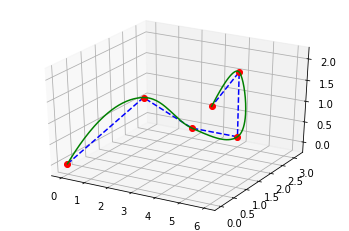

In [2]:
# Testing the cubic Bezier segments

# Creating some waypoints
q_x = [0, 1, 2, 4, 5, 6]
q_y = [0, 2, 3, 3, 2, 0]
q_z = [0, 1, 0, 0, 2, 2]

q = [np.array([x, y, z]) for x, y, z in zip(q_x, q_y, q_z)]

# Plotting the original waypoints
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(q_x, q_y, q_z, 'b--')
ax.plot(q_x, q_y, q_z, 'ro')

# Computing the Bezier curve segments
segments = CubicBezierSegment.generate_cubic_curve(q)

# Computing the lengths
lengths = [seg.get_length() for seg in segments]
lengths = [0] + lengths
total_length = np.sum(lengths)

print('\tTotal length=', total_length)

u = np.cumsum(lengths) / total_length

# Interpolating on the Bezier curve
pnts = None
for i in np.linspace(0, 1, 200):
    idx = (u - i >= 0).nonzero()[0][0]
    if idx == 0:
        u_k = 0
        pnts = segments[idx].interpolate(u_k)
    else:
        u_k = (i - u[idx - 1]) / (u[idx] - u[idx - 1])
        pnts = np.vstack((pnts, segments[idx - 1].interpolate(u_k)))

# Plotting the interpolated points
ax.plot(pnts[:, 0], pnts[:, 1], pnts[:, 2], 'g')    

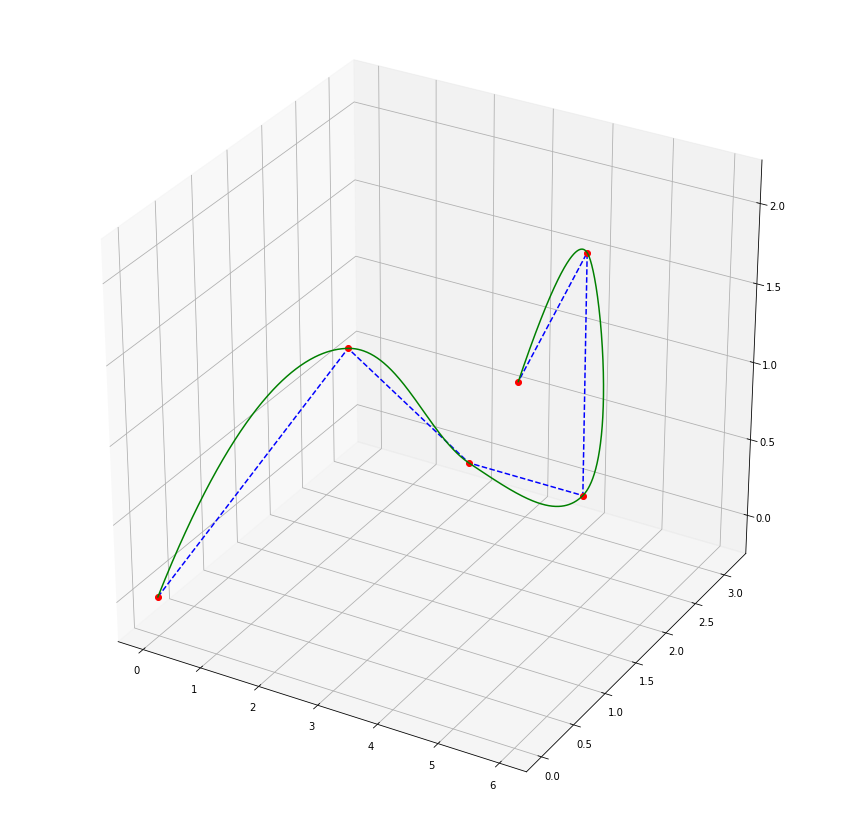

In [3]:
# Testing the CS interpolator

interpolator = CSInterpolator(q, 2.0)
interpolator.plot()

In [4]:
# Testing the position and rotation information from the Bezier curve

for i in np.linspace(0, 1, 11):
    pos, q = interpolator.generate_pnt(i)
    print('#%.1f' % i)
    print('\tPosition = ' + str(pos))
    print('\tRotation = ' + str(q))
    print('\tRotation matrix = \n' + str(q.rotation_matrix))

#0.0
	Position = [0. 0. 0.]
	Rotation = 1.000 +0.000i +0.000j +0.000k
	Rotation matrix = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
#0.1
	Position = [0.32815572 0.85134907 0.71823098]
	Rotation = 0.812 +0.140i -0.218j +0.523k
	Rotation matrix = 
[[ 3.58199391e-01 -9.10322652e-01 -2.07378557e-01]
 [ 7.87817187e-01  4.13899347e-01 -4.56104605e-01]
 [ 5.01036203e-01 -5.30885920e-18  8.65426325e-01]]
#0.2
	Position = [0.83799527 1.77182886 1.0296719 ]
	Rotation = 0.883 -0.003i +0.006j +0.470k
	Rotation matrix = 
[[ 5.57822551e-01 -8.29924659e-01  7.68520409e-03]
 [ 8.29845906e-01  5.57875489e-01  1.14329102e-02]
 [-1.37758411e-02  3.00487215e-20  9.99905109e-01]]
#0.3
	Position = [1.4130359  2.57054491 0.56920695]
	Rotation = 0.839 -0.159i +0.336j +0.397k
	Rotation matrix = 
[[ 4.59197512e-01 -7.73417287e-01  4.36993530e-01]
 [ 5.60266359e-01  6.33897232e-01  5.33175306e-01]
 [-6.89375987e-01 -2.72870892e-18  7.24403719e-01]]
#0.4
	Position = [ 2.16664872  3.05725887 -0.06057704]
	Rotation = 0.

First derivative #0.0
[0.10980904 0.33973119 0.35003527]
Second derivative #0.0
[-0.29107254 -0.39983401  0.0735496 ]
First derivative #0.1
[0.21333085 0.41256768 0.1851428 ]
Second derivative #0.1
[-0.20149008 -0.076667    0.45113625]
First derivative #0.2
[ 0.28723825  0.40630364 -0.04910747]
Second derivative #0.2
[-0.13623605  0.03552994  0.47976803]
First derivative #0.3
[ 0.26899126  0.25380822 -0.33648936]
Second derivative #0.3
[-0.20225277  0.39905021  0.22327728]
First derivative #0.4
[ 0.46666951  0.1154297  -0.1374611 ]
Second derivative #0.4
[-0.18596071  0.39098049 -0.25010571]
First derivative #0.5
[ 0.48318335 -0.07603501  0.1036944 ]
Second derivative #0.5
[ 0.0687478   0.23499964 -0.43594599]
First derivative #0.6
[ 0.27398574 -0.12419544  0.39938366]
Second derivative #0.6
[ 0.38663944  0.01800681 -0.31652124]
First derivative #0.7
[ 0.12892608 -0.24512498  0.41628333]
Second derivative #0.7
[0.08302631 0.45078601 0.19974634]
First derivative #0.8
[ 0.24372725 -0.379

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


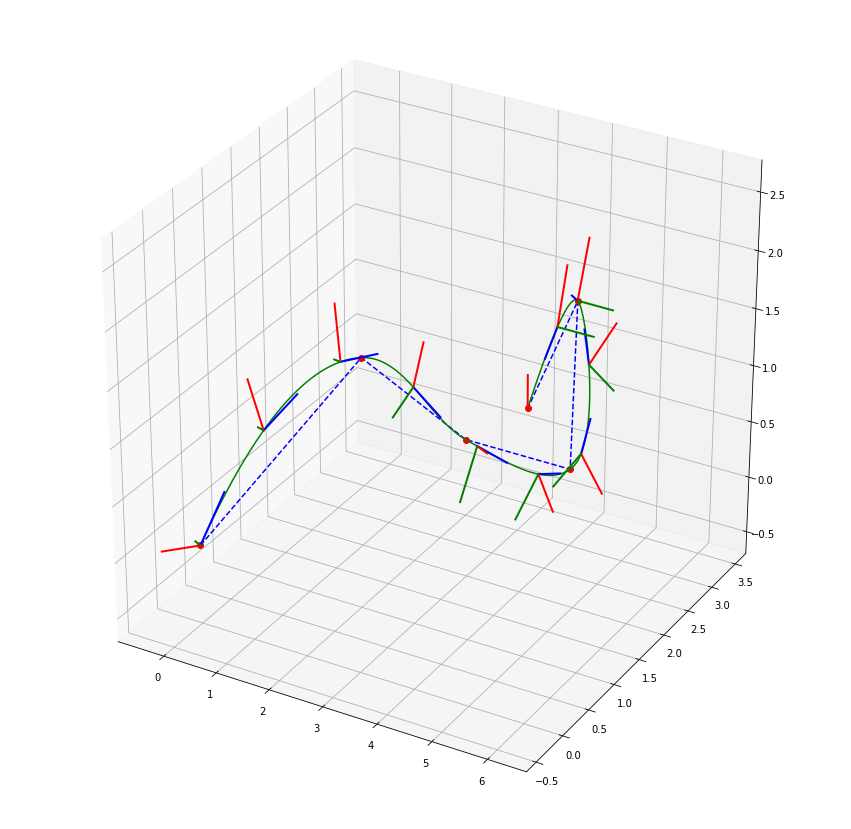

In [5]:
# Plotting the frames sampled over the Bezier curve path

ax = interpolator.plot()

vec_length = 0.5
for i in np.linspace(0, 1, 11):
    pos, q = interpolator.generate_pnt(i)
    
    print('First derivative #%.1f' % i)
    t = interpolator.get_derivative(i, order=1) 
    t /= np.linalg.norm(t)
    t *= vec_length
    print(str(t))
    
    ax.plot(
        [pos[0], pos[0] + t[0]],
        [pos[1], pos[1] + t[1]],
        [pos[2], pos[2] + t[2]], 'b', linewidth=2)
    
    print('Second derivative #%.1f' % i)
    n = interpolator.get_derivative(i, order=2) 
    n /= np.linalg.norm(n)
    n *= -1 * vec_length
    print(str(n))
    
    ax.plot(
        [pos[0], pos[0] + n[0]],
        [pos[1], pos[1] + n[1]],
        [pos[2], pos[2] + n[2]], 'r', linewidth=2)
    
    y = np.cross(n, t)
    y /= np.linalg.norm(y)
    y *= vec_length
    
    ax.plot(
        [pos[0], pos[0] + y[0]],
        [pos[1], pos[1] + y[1]],
        [pos[2], pos[2] + y[2]], 'g', linewidth=2)

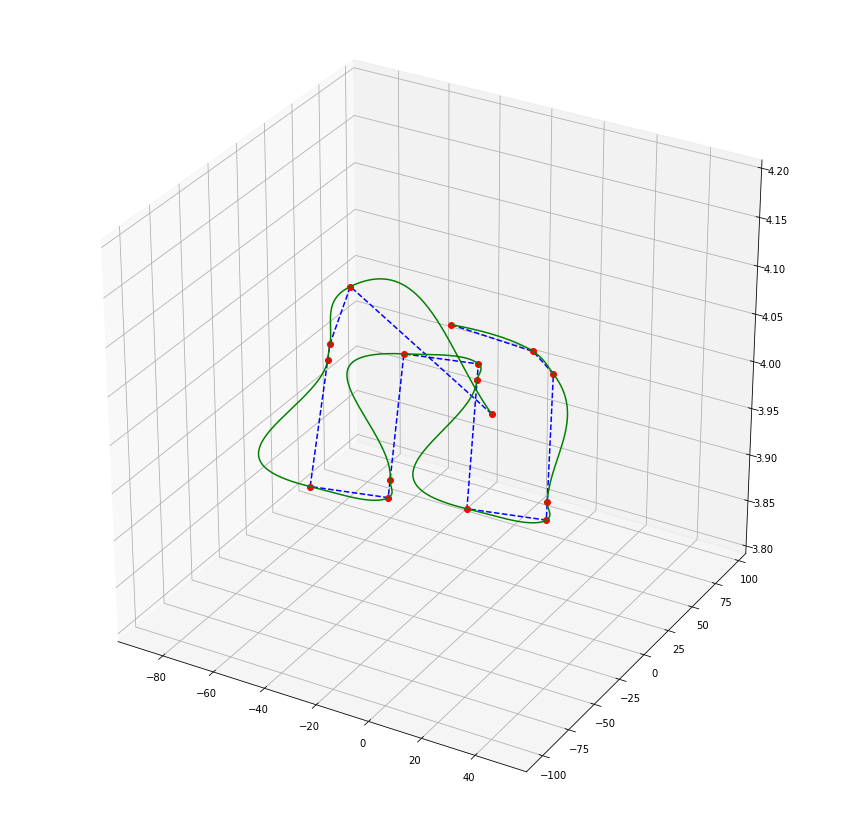

In [6]:
q_x = [0.0, -87.32176874282416, -71.70124691747081, -66.5800216933953, -27.239502197474394, -1.859834614768591, -7.010114928982462, -46.32241929004925, -20.943739002902298, -15.822320403686222, 23.491073829974827, 48.87044916385431, 43.74858730450777, 4.406183702195269, -9.155663806755259, -42.859897289027145]
q_y = [0.0, 77.59918805660998, 21.268401725015146, 7.217625477029927, -100.84533454447794, -91.64865197201635, -77.53411437223382, 30.528599671713895, 39.72513238990259, 25.674437069220325, -82.38790151834107, -73.19081629685304, -59.07635964269425, 48.98573316165627, 63.866676189149395, 67.89055013546674]
q_z = [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]

q = [np.array([x, y, z]) for x, y, z in zip(q_x, q_y, q_z)]

interpolator = CSInterpolator(q, 1.2)
interpolator.plot()